# Chapter 13: Multi-Agent Reinforcement Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/username/ReinforcementLearning/blob/main/notebooks/chapter13_multi_agent_rl.ipynb)

## Introduction

Multi-agent reinforcement learning (MARL) extends RL to environments with multiple learning agents that interact with each other. This introduces new challenges such as non-stationarity, partial observability, and credit assignment among agents.

### Key Topics Covered:
- Independent Learning vs Joint Action Learning
- Nash Equilibria and Game Theory
- Multi-Agent Deep Deterministic Policy Gradient (MADDPG)
- Centralized Training with Decentralized Execution
- Communication and Coordination
- Cooperative vs Competitive vs Mixed-Motive scenarios

## Mathematical Foundation

### Multi-Agent MDP (MAMDP)

A multi-agent MDP is defined by the tuple $(S, A_1, ..., A_n, P, R_1, ..., R_n, \gamma)$ where:
- $S$: State space
- $A_i$: Action space for agent $i$
- $P(s'|s, a_1, ..., a_n)$: Transition probability
- $R_i(s, a_1, ..., a_n)$: Reward function for agent $i$
- $\gamma$: Discount factor

### Nash Equilibrium

A Nash equilibrium is a joint policy $\pi^* = (\pi_1^*, ..., \pi_n^*)$ such that:
$$V_i^{\pi^*}(s) \geq V_i^{\pi_i', \pi_{-i}^*}(s) \quad \forall i, \pi_i', s$$

### Multi-Agent Policy Gradient

The policy gradient for agent $i$ in a multi-agent setting:
$$\nabla_{\theta_i} J_i(\theta_i) = \mathbb{E}_{\pi} \left[ \nabla_{\theta_i} \log \pi_i(a_i|s; \theta_i) Q_i^{\pi}(s, a_1, ..., a_n) \right]$$

### Centralized Training, Decentralized Execution (CTDE)

During training, agents can access global information:
$$Q_i(s, a_1, ..., a_n) \text{ (centralized)}$$

During execution, agents act independently:
$$\pi_i(a_i|o_i) \text{ (decentralized)}$$

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
from typing import List, Tuple, Dict, Optional
import copy

# Try to import PyTorch for neural network implementations
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torch.nn.functional as F
    from torch.distributions import Categorical, Normal
    HAS_TORCH = True
    print("PyTorch available - using neural network implementations")
except ImportError:
    HAS_TORCH = False
    print("PyTorch not available - using simplified implementations")

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
if HAS_TORCH:
    torch.manual_seed(42)

PyTorch available - using neural network implementations


## Multi-Agent Environments

We'll create several multi-agent environments to demonstrate different MARL concepts.

In [2]:
class PredatorPreyEnvironment:
    """Predator-Prey environment with multiple agents."""

    def __init__(self, grid_size=8, n_predators=2, n_prey=1):
        self.grid_size = grid_size
        self.n_predators = n_predators
        self.n_prey = n_prey
        self.n_agents = n_predators + n_prey

        # Action space: 0=up, 1=down, 2=left, 3=right, 4=stay
        self.action_space = 5
        self.action_map = [(-1, 0), (1, 0), (0, -1), (0, 1), (0, 0)]

        # State space: positions of all agents
        self.state_space = grid_size * grid_size

        self.reset()

    def reset(self):
        """Reset environment to initial state."""
        self.positions = []

        # Place agents randomly, ensuring no collisions
        occupied = set()
        for _ in range(self.n_agents):
            while True:
                pos = (np.random.randint(0, self.grid_size),
                      np.random.randint(0, self.grid_size))
                if pos not in occupied:
                    self.positions.append(pos)
                    occupied.add(pos)
                    break

        self.episode_steps = 0
        self.max_steps = 50

        return self.get_observations()

    def get_observations(self):
        """Get observations for each agent."""
        observations = []

        for i in range(self.n_agents):
            # Each agent observes relative positions of all other agents
            obs = []
            my_pos = self.positions[i]

            for j in range(self.n_agents):
                if i != j:
                    other_pos = self.positions[j]
                    relative_pos = (
                        other_pos[0] - my_pos[0],
                        other_pos[1] - my_pos[1]
                    )
                    obs.extend(relative_pos)

                    # Add agent type (predator=1, prey=0)
                    agent_type = 1 if j < self.n_predators else 0
                    obs.append(agent_type)

            # Add own position (normalized)
            obs.extend([my_pos[0] / self.grid_size, my_pos[1] / self.grid_size])

            observations.append(np.array(obs, dtype=np.float32))

        return observations

    def step(self, actions):
        """Execute actions for all agents."""
        assert len(actions) == self.n_agents

        # Calculate new positions
        new_positions = []
        for i, action in enumerate(actions):
            current_pos = self.positions[i]
            delta = self.action_map[action]
            new_pos = (
                max(0, min(self.grid_size - 1, current_pos[0] + delta[0])),
                max(0, min(self.grid_size - 1, current_pos[1] + delta[1]))
            )
            new_positions.append(new_pos)

        self.positions = new_positions
        self.episode_steps += 1

        # Calculate rewards
        rewards = self.calculate_rewards()

        # Check if episode is done
        done = self.is_done()

        return self.get_observations(), rewards, done, {}

    def calculate_rewards(self):
        """Calculate rewards for all agents."""
        rewards = [0.0] * self.n_agents

        # Check for captures (predator and prey in same position)
        predator_positions = self.positions[:self.n_predators]
        prey_positions = self.positions[self.n_predators:]

        captured = False
        for i, pred_pos in enumerate(predator_positions):
            for j, prey_pos in enumerate(prey_positions):
                if pred_pos == prey_pos:
                    # Predator gets positive reward
                    rewards[i] += 10.0
                    # Prey gets negative reward
                    rewards[self.n_predators + j] -= 10.0
                    captured = True

        # Distance-based rewards
        if not captured:
            for i in range(self.n_predators):
                min_distance = float('inf')
                for j in range(self.n_prey):
                    distance = abs(self.positions[i][0] - self.positions[self.n_predators + j][0]) + \
                              abs(self.positions[i][1] - self.positions[self.n_predators + j][1])
                    min_distance = min(min_distance, distance)

                # Predator gets reward for being close to prey
                rewards[i] += (self.grid_size - min_distance) / self.grid_size * 0.1

            for j in range(self.n_prey):
                min_distance = float('inf')
                for i in range(self.n_predators):
                    distance = abs(self.positions[i][0] - self.positions[self.n_predators + j][0]) + \
                              abs(self.positions[i][1] - self.positions[self.n_predators + j][1])
                    min_distance = min(min_distance, distance)

                # Prey gets reward for being far from predators
                rewards[self.n_predators + j] += min_distance / self.grid_size * 0.1

        return rewards

    def is_done(self):
        """Check if episode is finished."""
        # Episode ends if prey is captured or max steps reached
        predator_positions = self.positions[:self.n_predators]
        prey_positions = self.positions[self.n_predators:]

        for pred_pos in predator_positions:
            for prey_pos in prey_positions:
                if pred_pos == prey_pos:
                    return True

        return self.episode_steps >= self.max_steps

    def render(self):
        """Visualize the current state."""
        grid = np.zeros((self.grid_size, self.grid_size))

        # Mark predators (value 1)
        for i in range(self.n_predators):
            pos = self.positions[i]
            grid[pos[0], pos[1]] = 1

        # Mark prey (value 2)
        for i in range(self.n_prey):
            pos = self.positions[self.n_predators + i]
            grid[pos[0], pos[1]] = 2

        return grid

class CooperativeNavigationEnvironment:
    """Cooperative navigation environment with multiple agents."""

    def __init__(self, n_agents=3, n_landmarks=3, world_size=2.0):
        self.n_agents = n_agents
        self.n_landmarks = n_landmarks
        self.world_size = world_size

        # Continuous action space (2D movement)
        self.action_dim = 2
        self.max_speed = 0.1

        self.reset()

    def reset(self):
        """Reset environment to initial state."""
        # Random agent positions
        self.agent_positions = np.random.uniform(
            -self.world_size, self.world_size, (self.n_agents, 2)
        )

        # Random landmark positions
        self.landmark_positions = np.random.uniform(
            -self.world_size, self.world_size, (self.n_landmarks, 2)
        )

        self.episode_steps = 0
        self.max_steps = 50

        return self.get_observations()

    def get_observations(self):
        """Get observations for each agent."""
        observations = []

        for i in range(self.n_agents):
            obs = []

            # Own position
            obs.extend(self.agent_positions[i])

            # Relative positions to other agents
            for j in range(self.n_agents):
                if i != j:
                    relative_pos = self.agent_positions[j] - self.agent_positions[i]
                    obs.extend(relative_pos)

            # Relative positions to landmarks
            for landmark_pos in self.landmark_positions:
                relative_pos = landmark_pos - self.agent_positions[i]
                obs.extend(relative_pos)

            observations.append(np.array(obs, dtype=np.float32))

        return observations

    def step(self, actions):
        """Execute actions for all agents."""
        assert len(actions) == self.n_agents

        # Update agent positions
        for i, action in enumerate(actions):
            # Clip actions
            action = np.clip(action, -1, 1)

            # Update position
            self.agent_positions[i] += action * self.max_speed

            # Keep agents within world bounds
            self.agent_positions[i] = np.clip(
                self.agent_positions[i], -self.world_size, self.world_size
            )

        self.episode_steps += 1

        # Calculate rewards
        rewards = self.calculate_rewards()

        # Check if episode is done
        done = self.episode_steps >= self.max_steps

        return self.get_observations(), rewards, done, {}

    def calculate_rewards(self):
        """Calculate cooperative rewards."""
        # Global reward based on how well agents cover landmarks
        total_distance = 0

        for landmark_pos in self.landmark_positions:
            # Find closest agent to this landmark
            min_distance = float('inf')
            for agent_pos in self.agent_positions:
                distance = np.linalg.norm(agent_pos - landmark_pos)
                min_distance = min(min_distance, distance)
            total_distance += min_distance

        # Shared reward (cooperative)
        global_reward = -total_distance

        # Add collision penalty
        collision_penalty = 0
        for i in range(self.n_agents):
            for j in range(i + 1, self.n_agents):
                distance = np.linalg.norm(self.agent_positions[i] - self.agent_positions[j])
                if distance < 0.1:  # Collision threshold
                    collision_penalty -= 1.0

        # All agents get the same reward (fully cooperative)
        rewards = [global_reward + collision_penalty] * self.n_agents

        return rewards

# Test environments
predator_prey_env = PredatorPreyEnvironment()
coop_nav_env = CooperativeNavigationEnvironment()

print(f"Predator-Prey: {predator_prey_env.n_agents} agents, grid size {predator_prey_env.grid_size}")
print(f"Cooperative Navigation: {coop_nav_env.n_agents} agents, continuous space")

# Test observation shapes
pp_obs = predator_prey_env.reset()
cn_obs = coop_nav_env.reset()
print(f"Predator-Prey observation shape: {[obs.shape for obs in pp_obs]}")
print(f"Cooperative Navigation observation shape: {[obs.shape for obs in cn_obs]}")

Predator-Prey: 3 agents, grid size 8
Cooperative Navigation: 3 agents, continuous space
Predator-Prey observation shape: [(8,), (8,), (8,)]
Cooperative Navigation observation shape: [(12,), (12,), (12,)]


## Independent Learning Agents

The simplest approach to MARL is to train each agent independently, treating other agents as part of the environment.

In [3]:
if HAS_TORCH:
    class IndependentAgent(nn.Module):
        """Independent learning agent using DQN or policy gradient."""

        def __init__(self, obs_dim, action_dim, hidden_dim=64, discrete_actions=True):
            super(IndependentAgent, self).__init__()
            self.obs_dim = obs_dim
            self.action_dim = action_dim
            self.discrete_actions = discrete_actions

            # Shared layers
            self.fc1 = nn.Linear(obs_dim, hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, hidden_dim)

            if discrete_actions:
                # Q-values for discrete actions
                self.q_head = nn.Linear(hidden_dim, action_dim)
            else:
                # Mean and log std for continuous actions
                self.mean_head = nn.Linear(hidden_dim, action_dim)
                self.log_std_head = nn.Linear(hidden_dim, action_dim)

        def forward(self, obs):
            x = torch.relu(self.fc1(obs))
            x = torch.relu(self.fc2(x))

            if self.discrete_actions:
                q_values = self.q_head(x)
                return q_values
            else:
                mean = torch.tanh(self.mean_head(x))
                log_std = self.log_std_head(x)
                return mean, log_std

        def get_action(self, obs, epsilon=0.1):
            """Get action from observation."""
            with torch.no_grad():
                if self.discrete_actions:
                    q_values = self.forward(obs)
                    if np.random.random() < epsilon:
                        action = np.random.randint(self.action_dim)
                    else:
                        action = q_values.argmax().item()
                    return action
                else:
                    mean, log_std = self.forward(obs)
                    std = torch.exp(log_std)
                    dist = Normal(mean, std)
                    action = dist.sample()
                    return action.numpy()

class IndependentLearning:
    """Independent learning for multiple agents."""

    def __init__(self, env, obs_dims, action_dims, discrete_actions=True, lr=1e-3):
        self.env = env
        self.n_agents = len(obs_dims)
        self.discrete_actions = discrete_actions

        if HAS_TORCH:
            # Create independent agents
            self.agents = []
            self.optimizers = []

            for i in range(self.n_agents):
                agent = IndependentAgent(
                    obs_dims[i], action_dims[i], discrete_actions=discrete_actions
                )
                optimizer = optim.Adam(agent.parameters(), lr=lr)

                self.agents.append(agent)
                self.optimizers.append(optimizer)

        # Experience replay buffers
        self.replay_buffers = [deque(maxlen=10000) for _ in range(self.n_agents)]

        # Training statistics
        self.episode_rewards = [[] for _ in range(self.n_agents)]
        self.episode_lengths = []

    def collect_experience(self, episodes=100):
        """Collect experience for training."""
        for episode in range(episodes):
            observations = self.env.reset()
            episode_rewards = [0] * self.n_agents
            steps = 0

            while True:
                # Get actions from all agents
                actions = []
                for i in range(self.n_agents):
                    if HAS_TORCH:
                        obs_tensor = torch.FloatTensor(observations[i]).unsqueeze(0)
                        action = self.agents[i].get_action(obs_tensor, epsilon=0.3)
                    else:
                        action = np.random.randint(5) if self.discrete_actions else np.random.uniform(-1, 1, 2)
                    actions.append(action)

                # Execute actions
                next_observations, rewards, done, _ = self.env.step(actions)

                # Store experiences
                for i in range(self.n_agents):
                    self.replay_buffers[i].append((
                        observations[i], actions[i], rewards[i],
                        next_observations[i], done
                    ))
                    episode_rewards[i] += rewards[i]

                observations = next_observations
                steps += 1

                if done or steps > 100:
                    break

            # Store episode statistics
            for i in range(self.n_agents):
                self.episode_rewards[i].append(episode_rewards[i])
            self.episode_lengths.append(steps)

            if episode % 20 == 0:
                avg_rewards = [np.mean(self.episode_rewards[i][-10:]) for i in range(self.n_agents)]
                print(f"Episode {episode}, Avg Rewards: {[f'{r:.2f}' for r in avg_rewards]}")

    def train(self, batch_size=32, train_steps=1000):
        """Train all agents independently."""
        if not HAS_TORCH:
            print("Training requires PyTorch")
            return

        for step in range(train_steps):
            for i in range(self.n_agents):
                if len(self.replay_buffers[i]) < batch_size:
                    continue

                # Sample batch
                batch = random.sample(self.replay_buffers[i], batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)

                states = torch.FloatTensor(states)
                rewards = torch.FloatTensor(rewards)
                dones = torch.BoolTensor(dones)
                next_states = torch.FloatTensor(next_states)

                if self.discrete_actions:
                    actions = torch.LongTensor(actions)

                    # DQN update
                    q_values = self.agents[i](states)
                    next_q_values = self.agents[i](next_states)

                    q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
                    next_q_value = next_q_values.max(1)[0].detach()
                    target = rewards + 0.99 * next_q_value * (~dones)

                    loss = F.mse_loss(q_value, target)
                else:
                    actions = torch.FloatTensor(actions)

                    # Policy gradient update (simplified)
                    mean, log_std = self.agents[i](states)
                    std = torch.exp(log_std)
                    dist = Normal(mean, std)

                    log_prob = dist.log_prob(actions).sum(dim=1)
                    loss = -(log_prob * rewards).mean()

                # Backward pass
                self.optimizers[i].zero_grad()
                loss.backward()
                self.optimizers[i].step()

            if step % 200 == 0:
                print(f"Training step {step} completed")

# Train independent agents on Predator-Prey
pp_env = PredatorPreyEnvironment()
pp_obs_dims = [len(obs) for obs in pp_env.reset()]
pp_action_dims = [pp_env.action_space] * pp_env.n_agents

independent_learner = IndependentLearning(
    pp_env, pp_obs_dims, pp_action_dims, discrete_actions=True
)

print("Training independent agents on Predator-Prey...")
independent_learner.collect_experience(episodes=100)

if HAS_TORCH:
    independent_learner.train(train_steps=500)
    print("Independent learning training completed")
else:
    print("Training skipped - PyTorch not available")

Training independent agents on Predator-Prey...
Episode 0, Avg Rewards: ['-0.03', '-1.29', '4.97']
Episode 20, Avg Rewards: ['2.42', '0.37', '0.40']
Episode 40, Avg Rewards: ['1.40', '1.41', '1.11']
Episode 60, Avg Rewards: ['4.28', '0.13', '-1.62']
Episode 80, Avg Rewards: ['3.79', '1.26', '-1.85']


/tmp/ipython-input-994961216.py:140: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.FloatTensor(states)


Training step 0 completed
Training step 200 completed
Training step 400 completed
Independent learning training completed


## Multi-Agent Deep Deterministic Policy Gradient (MADDPG)

MADDPG uses centralized training with decentralized execution for continuous control.

In [4]:
if HAS_TORCH:
    class Actor(nn.Module):
        """Actor network for MADDPG."""

        def __init__(self, obs_dim, action_dim, hidden_dim=64):
            super(Actor, self).__init__()
            self.fc1 = nn.Linear(obs_dim, hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, hidden_dim)
            self.action_head = nn.Linear(hidden_dim, action_dim)

        def forward(self, obs):
            x = torch.relu(self.fc1(obs))
            x = torch.relu(self.fc2(x))
            action = torch.tanh(self.action_head(x))
            return action

    class Critic(nn.Module):
        """Critic network for MADDPG (centralized)."""

        def __init__(self, total_obs_dim, total_action_dim, hidden_dim=64):
            super(Critic, self).__init__()
            # Critic takes all observations and all actions as input
            self.fc1 = nn.Linear(total_obs_dim + total_action_dim, hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, hidden_dim)
            self.q_head = nn.Linear(hidden_dim, 1)

        def forward(self, obs, actions):
            x = torch.cat([obs, actions], dim=1)
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            q_value = self.q_head(x)
            return q_value

class MADDPG:
    """Multi-Agent Deep Deterministic Policy Gradient."""

    def __init__(self, env, obs_dims, action_dims, lr=1e-3, gamma=0.95, tau=0.01):
        self.env = env
        self.n_agents = len(obs_dims)
        self.obs_dims = obs_dims
        self.action_dims = action_dims
        self.gamma = gamma
        self.tau = tau

        # Calculate total dimensions for centralized critic
        self.total_obs_dim = sum(obs_dims)
        self.total_action_dim = sum(action_dims)

        if HAS_TORCH:
            # Create actors and critics for each agent
            self.actors = []
            self.target_actors = []
            self.critics = []
            self.target_critics = []
            self.actor_optimizers = []
            self.critic_optimizers = []

            for i in range(self.n_agents):
                # Actor (decentralized - uses only local observation)
                actor = Actor(obs_dims[i], action_dims[i])
                target_actor = Actor(obs_dims[i], action_dims[i])
                target_actor.load_state_dict(actor.state_dict())

                # Critic (centralized - uses global state and actions)
                critic = Critic(self.total_obs_dim, self.total_action_dim)
                target_critic = Critic(self.total_obs_dim, self.total_action_dim)
                target_critic.load_state_dict(critic.state_dict())

                # Optimizers
                actor_optimizer = optim.Adam(actor.parameters(), lr=lr)
                critic_optimizer = optim.Adam(critic.parameters(), lr=lr)

                self.actors.append(actor)
                self.target_actors.append(target_actor)
                self.critics.append(critic)
                self.target_critics.append(target_critic)
                self.actor_optimizers.append(actor_optimizer)
                self.critic_optimizers.append(critic_optimizer)

        # Replay buffer
        self.replay_buffer = deque(maxlen=100000)

        # Statistics
        self.episode_rewards = [[] for _ in range(self.n_agents)]
        self.episode_lengths = []

    def get_actions(self, observations, add_noise=True, noise_scale=0.1):
        """Get actions from all actors."""
        actions = []

        if HAS_TORCH:
            for i, obs in enumerate(observations):
                obs_tensor = torch.FloatTensor(obs).unsqueeze(0)
                with torch.no_grad():
                    action = self.actors[i](obs_tensor).squeeze(0).numpy()

                if add_noise:
                    noise = np.random.normal(0, noise_scale, action.shape)
                    action = np.clip(action + noise, -1, 1)

                actions.append(action)
        else:
            # Random actions as fallback
            for i in range(self.n_agents):
                action = np.random.uniform(-1, 1, self.action_dims[i])
                actions.append(action)

        return actions

    def store_experience(self, obs, actions, rewards, next_obs, done):
        """Store experience in replay buffer."""
        # Flatten observations and actions for centralized storage
        flat_obs = np.concatenate(obs)
        flat_actions = np.concatenate(actions)
        flat_next_obs = np.concatenate(next_obs)

        self.replay_buffer.append((
            obs, actions, rewards, next_obs, done,
            flat_obs, flat_actions, flat_next_obs
        ))

    def train(self, batch_size=64):
        """Train MADDPG agents."""
        if not HAS_TORCH or len(self.replay_buffer) < batch_size:
            return

        # Sample batch
        batch = random.sample(self.replay_buffer, batch_size)

        # Unpack batch
        obs_batch = []
        actions_batch = []
        rewards_batch = []
        next_obs_batch = []
        done_batch = []
        flat_obs_batch = []
        flat_actions_batch = []
        flat_next_obs_batch = []

        for experience in batch:
            obs, actions, rewards, next_obs, done, flat_obs, flat_actions, flat_next_obs = experience
            obs_batch.append(obs)
            actions_batch.append(actions)
            rewards_batch.append(rewards)
            next_obs_batch.append(next_obs)
            done_batch.append(done)
            flat_obs_batch.append(flat_obs)
            flat_actions_batch.append(flat_actions)
            flat_next_obs_batch.append(flat_next_obs)

        flat_obs_batch = torch.FloatTensor(flat_obs_batch)
        flat_actions_batch = torch.FloatTensor(flat_actions_batch)
        flat_next_obs_batch = torch.FloatTensor(flat_next_obs_batch)
        done_batch = torch.BoolTensor(done_batch)

        # Train each agent
        for agent_idx in range(self.n_agents):
            # Extract agent-specific data
            agent_obs = torch.FloatTensor([obs[agent_idx] for obs in obs_batch])
            agent_actions = torch.FloatTensor([actions[agent_idx] for actions in actions_batch])
            agent_rewards = torch.FloatTensor([rewards[agent_idx] for rewards in rewards_batch])
            agent_next_obs = torch.FloatTensor([next_obs[agent_idx] for next_obs in next_obs_batch])

            # Update Critic
            with torch.no_grad():
                # Get next actions from target actors
                next_actions = []
                for i in range(self.n_agents):
                    next_obs_i = torch.FloatTensor([next_obs[i] for next_obs in next_obs_batch])
                    next_action_i = self.target_actors[i](next_obs_i)
                    next_actions.append(next_action_i)

                next_actions_concat = torch.cat(next_actions, dim=1)

                # Compute target Q-value
                target_q = self.target_critics[agent_idx](flat_next_obs_batch, next_actions_concat)
                target_q = agent_rewards.unsqueeze(1) + self.gamma * target_q * (~done_batch).unsqueeze(1)

            # Current Q-value
            current_q = self.critics[agent_idx](flat_obs_batch, flat_actions_batch)

            # Critic loss
            critic_loss = F.mse_loss(current_q, target_q)

            # Update critic
            self.critic_optimizers[agent_idx].zero_grad()
            critic_loss.backward()
            self.critic_optimizers[agent_idx].step()

            # Update Actor
            # Get actions from current actor
            current_actions = []
            for i in range(self.n_agents):
                obs_i = torch.FloatTensor([obs[i] for obs in obs_batch])
                if i == agent_idx:
                    action_i = self.actors[i](obs_i)
                else:
                    with torch.no_grad():
                        action_i = self.actors[i](obs_i)
                current_actions.append(action_i)

            current_actions_concat = torch.cat(current_actions, dim=1)

            # Actor loss (maximize Q-value)
            actor_loss = -self.critics[agent_idx](flat_obs_batch, current_actions_concat).mean()

            # Update actor
            self.actor_optimizers[agent_idx].zero_grad()
            actor_loss.backward()
            self.actor_optimizers[agent_idx].step()

            # Soft update target networks
            self.soft_update(self.actors[agent_idx], self.target_actors[agent_idx])
            self.soft_update(self.critics[agent_idx], self.target_critics[agent_idx])

    def soft_update(self, source, target):
        """Soft update target network."""
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(
                self.tau * source_param.data + (1.0 - self.tau) * target_param.data
            )

    def train_episodes(self, episodes=100):
        """Train MADDPG for multiple episodes."""
        for episode in range(episodes):
            observations = self.env.reset()
            episode_rewards = [0] * self.n_agents
            steps = 0

            while True:
                # Get actions
                actions = self.get_actions(observations, add_noise=True)

                # Execute actions
                next_observations, rewards, done, _ = self.env.step(actions)

                # Store experience
                self.store_experience(observations, actions, rewards, next_observations, done)

                # Update statistics
                for i in range(self.n_agents):
                    episode_rewards[i] += rewards[i]

                observations = next_observations
                steps += 1

                # Train agents
                if len(self.replay_buffer) > 1000:
                    self.train()

                if done or steps > 100:
                    break

            # Store episode statistics
            for i in range(self.n_agents):
                self.episode_rewards[i].append(episode_rewards[i])
            self.episode_lengths.append(steps)

            if episode % 20 == 0:
                avg_rewards = [np.mean(self.episode_rewards[i][-10:]) for i in range(self.n_agents)]
                print(f"Episode {episode}, Avg Rewards: {[f'{r:.2f}' for r in avg_rewards]}")

# Train MADDPG on Cooperative Navigation
coop_env = CooperativeNavigationEnvironment()
coop_obs_dims = [len(obs) for obs in coop_env.reset()]
coop_action_dims = [coop_env.action_dim] * coop_env.n_agents

if HAS_TORCH:
    maddpg = MADDPG(coop_env, coop_obs_dims, coop_action_dims)

    print("Training MADDPG on Cooperative Navigation...")
    maddpg.train_episodes(episodes=100)
    print("MADDPG training completed")
else:
    print("MADDPG training skipped - PyTorch not available")

Training MADDPG on Cooperative Navigation...
Episode 0, Avg Rewards: ['-182.05', '-182.05', '-182.05']
Episode 20, Avg Rewards: ['-189.22', '-189.22', '-189.22']
Episode 40, Avg Rewards: ['-196.59', '-196.59', '-196.59']
Episode 60, Avg Rewards: ['-184.81', '-184.81', '-184.81']
Episode 80, Avg Rewards: ['-189.61', '-189.61', '-189.61']
MADDPG training completed


## Performance Analysis and Comparison

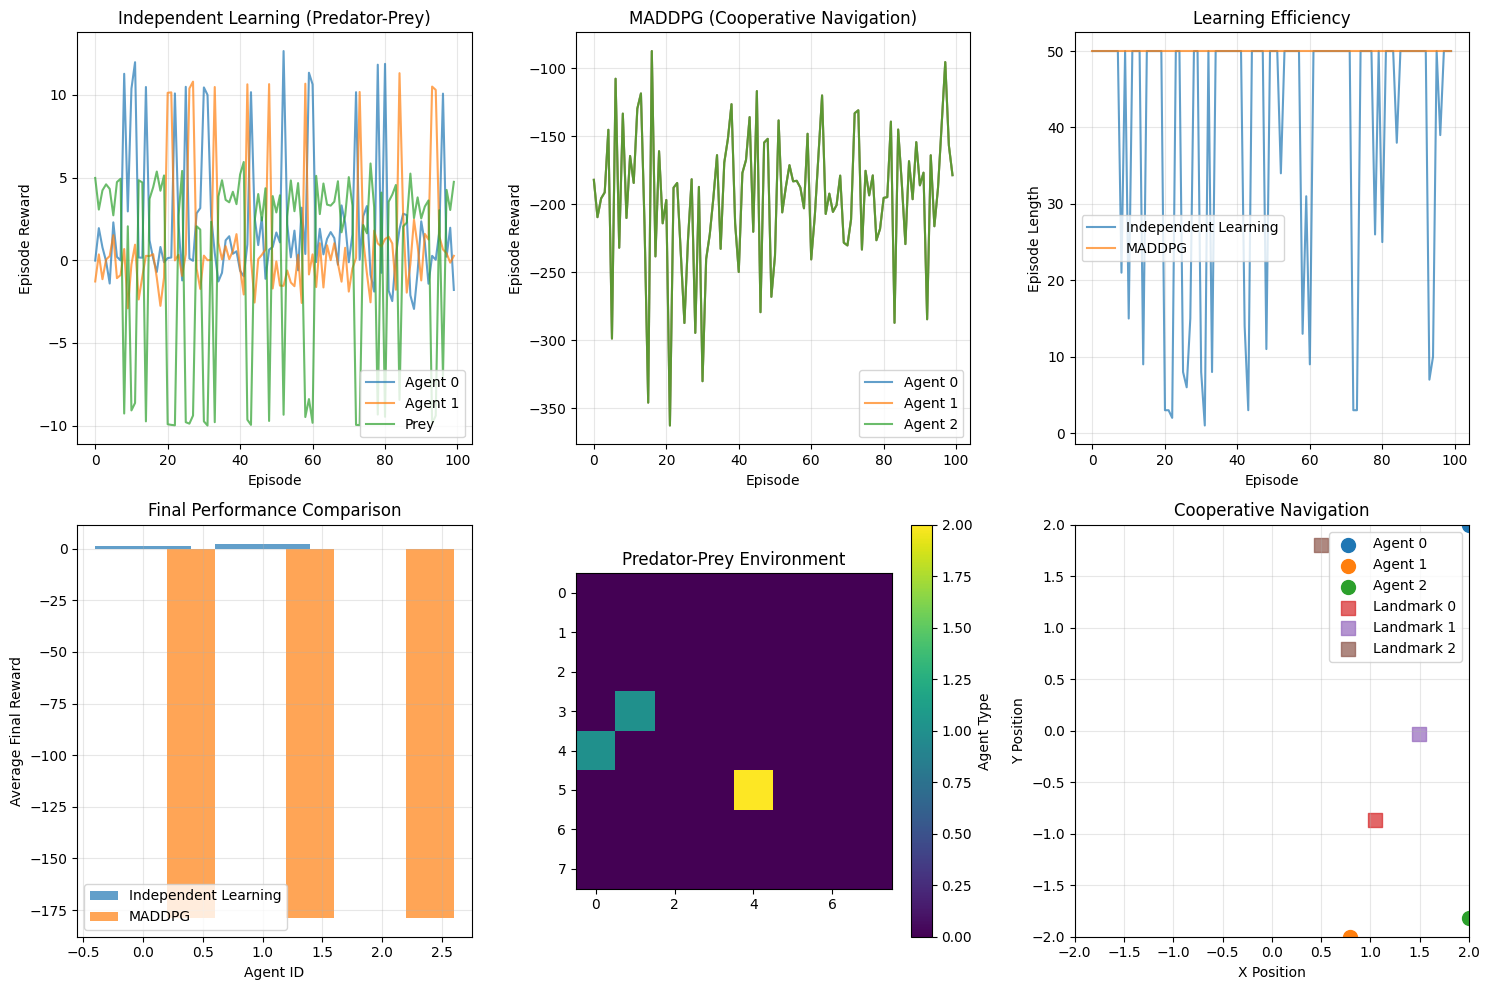


=== Multi-Agent Learning Comparison ===

Independent Learning (Predator-Prey):
  Predator 0: 1.45 ± 3.15
  Predator 1: 2.50 ± 4.03
  Prey 2: -0.19 ± 5.69

MADDPG (Cooperative Navigation):
  Agent 0: -178.86 ± 46.61
  Agent 1: -178.86 ± 46.61
  Agent 2: -178.86 ± 46.61

=== Multi-Agent Dynamics Analysis ===

1. **Independent Learning Challenges**:
   - Non-stationarity due to other learning agents
   - Difficulty in credit assignment
   - May converge to suboptimal Nash equilibria

2. **MADDPG Advantages**:
   - Centralized training addresses non-stationarity
   - Better coordination through global information
   - Maintains decentralized execution for scalability

3. **Environment Characteristics**:
   - Predator-Prey: Mixed-motive (competitive/cooperative)
   - Cooperative Navigation: Fully cooperative
   - Different environments require different approaches



In [5]:
# Compare multi-agent learning approaches
plt.figure(figsize=(15, 10))

# Independent Learning Results
if independent_learner.episode_rewards[0]:
    plt.subplot(2, 3, 1)
    for i in range(independent_learner.n_agents):
        plt.plot(independent_learner.episode_rewards[i],
                label=f'Agent {i}' if i < 2 else 'Prey', alpha=0.7)
    plt.xlabel('Episode')
    plt.ylabel('Episode Reward')
    plt.title('Independent Learning (Predator-Prey)')
    plt.legend()
    plt.grid(True, alpha=0.3)

# MADDPG Results
if HAS_TORCH and 'maddpg' in locals() and maddpg.episode_rewards[0]:
    plt.subplot(2, 3, 2)
    for i in range(maddpg.n_agents):
        plt.plot(maddpg.episode_rewards[i],
                label=f'Agent {i}', alpha=0.7)
    plt.xlabel('Episode')
    plt.ylabel('Episode Reward')
    plt.title('MADDPG (Cooperative Navigation)')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Episode lengths comparison
plt.subplot(2, 3, 3)
if independent_learner.episode_lengths:
    plt.plot(independent_learner.episode_lengths,
            label='Independent Learning', alpha=0.7)
if HAS_TORCH and 'maddpg' in locals() and maddpg.episode_lengths:
    plt.plot(maddpg.episode_lengths,
            label='MADDPG', alpha=0.7)
plt.xlabel('Episode')
plt.ylabel('Episode Length')
plt.title('Learning Efficiency')
plt.legend()
plt.grid(True, alpha=0.3)

# Reward distribution analysis
plt.subplot(2, 3, 4)
if independent_learner.episode_rewards[0]:
    final_rewards_il = [np.mean(independent_learner.episode_rewards[i][-10:])
                       for i in range(independent_learner.n_agents)]
    plt.bar(range(len(final_rewards_il)), final_rewards_il,
           alpha=0.7, label='Independent Learning')

if HAS_TORCH and 'maddpg' in locals() and maddpg.episode_rewards[0]:
    final_rewards_maddpg = [np.mean(maddpg.episode_rewards[i][-10:])
                           for i in range(maddpg.n_agents)]
    x_offset = np.arange(len(final_rewards_maddpg)) + 0.4
    plt.bar(x_offset, final_rewards_maddpg,
           alpha=0.7, label='MADDPG', width=0.4)

plt.xlabel('Agent ID')
plt.ylabel('Average Final Reward')
plt.title('Final Performance Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Environment visualizations
plt.subplot(2, 3, 5)
pp_grid = predator_prey_env.render()
plt.imshow(pp_grid, cmap='viridis')
plt.title('Predator-Prey Environment')
plt.colorbar(label='Agent Type')

plt.subplot(2, 3, 6)
# Visualization of agent positions in cooperative navigation
agent_positions = coop_env.agent_positions
landmark_positions = coop_env.landmark_positions

for i, pos in enumerate(agent_positions):
    plt.scatter(pos[0], pos[1], s=100, label=f'Agent {i}', marker='o')

for i, pos in enumerate(landmark_positions):
    plt.scatter(pos[0], pos[1], s=100, label=f'Landmark {i}', marker='s', alpha=0.7)

plt.xlim(-coop_env.world_size, coop_env.world_size)
plt.ylim(-coop_env.world_size, coop_env.world_size)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Cooperative Navigation')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n=== Multi-Agent Learning Comparison ===")

if independent_learner.episode_rewards[0]:
    print("\nIndependent Learning (Predator-Prey):")
    for i in range(independent_learner.n_agents):
        agent_type = "Predator" if i < predator_prey_env.n_predators else "Prey"
        final_reward = np.mean(independent_learner.episode_rewards[i][-10:])
        print(f"  {agent_type} {i}: {final_reward:.2f} ± {np.std(independent_learner.episode_rewards[i][-10:]):.2f}")

if HAS_TORCH and 'maddpg' in locals() and maddpg.episode_rewards[0]:
    print("\nMADDPG (Cooperative Navigation):")
    for i in range(maddpg.n_agents):
        final_reward = np.mean(maddpg.episode_rewards[i][-10:])
        print(f"  Agent {i}: {final_reward:.2f} ± {np.std(maddpg.episode_rewards[i][-10:]):.2f}")

# Analyze cooperation and competition
print("\n=== Multi-Agent Dynamics Analysis ===")
print("""
1. **Independent Learning Challenges**:
   - Non-stationarity due to other learning agents
   - Difficulty in credit assignment
   - May converge to suboptimal Nash equilibria

2. **MADDPG Advantages**:
   - Centralized training addresses non-stationarity
   - Better coordination through global information
   - Maintains decentralized execution for scalability

3. **Environment Characteristics**:
   - Predator-Prey: Mixed-motive (competitive/cooperative)
   - Cooperative Navigation: Fully cooperative
   - Different environments require different approaches
""")

## Advanced Multi-Agent Concepts

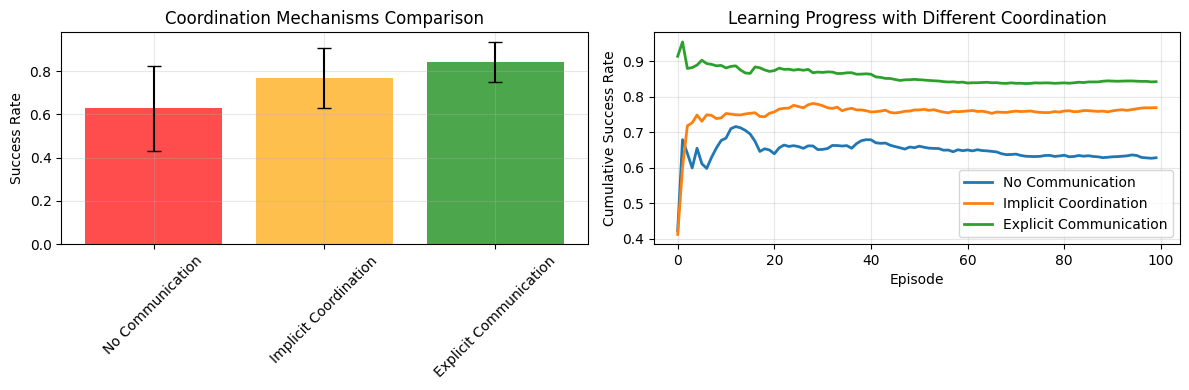


=== Game Theory Analysis ===
Prisoner's Dilemma Payoff Matrix:
                Agent 2
              Coop  Defect
Agent 1 Coop   [3 3]   [0 5]
       Defect  [5 0]   [1 1]

Strategy Analysis:
Always Cooperate vs Always Cooperate: (3.00, 3.00)
Always Cooperate vs Always Defect: (0.00, 5.00)
Always Cooperate vs Tit-for-Tat: (2.70, 3.20)
Always Cooperate vs Random: (1.50, 4.00)
Always Defect vs Always Defect: (1.00, 1.00)
Always Defect vs Tit-for-Tat: (4.60, 0.10)
Always Defect vs Random: (3.00, 0.50)
Tit-for-Tat vs Tit-for-Tat: (2.89, 2.89)
Random vs Tit-for-Tat: (3.65, 1.65)
Random vs Random: (2.25, 2.25)


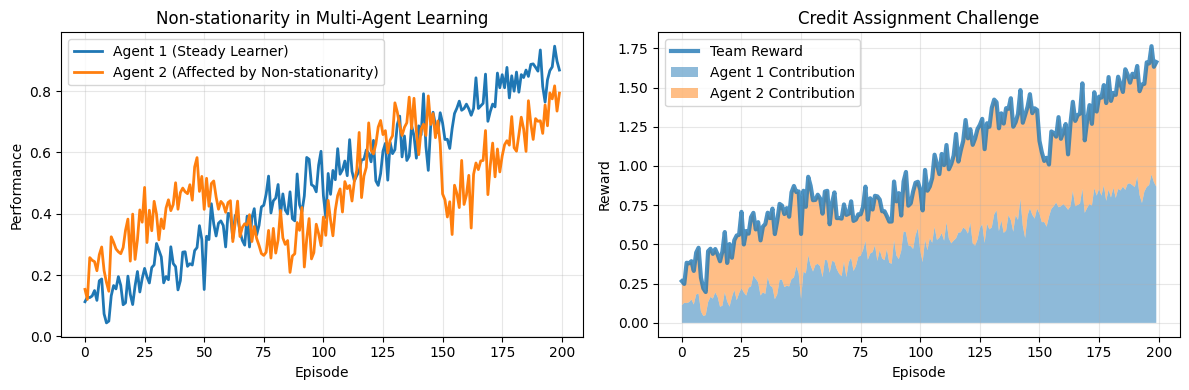


=== Key MARL Insights ===

1. **Non-stationarity**: Other agents' changing policies make the environment
   non-stationary from each agent's perspective.

2. **Credit Assignment**: Determining individual contributions to team success
   is challenging in cooperative settings.

3. **Scalability**: Coordination becomes increasingly difficult as the number
   of agents grows (curse of dimensionality).

4. **Communication**: Explicit communication can improve coordination but
   requires additional infrastructure and learning.

5. **Equilibrium Concepts**: Different solution concepts (Nash, Pareto optimal)
   lead to different optimal policies.



In [6]:
# Communication and coordination analysis
def analyze_agent_coordination():
    """Analyze coordination patterns in multi-agent systems."""

    # Simulate different coordination scenarios
    scenarios = {
        'No Communication': np.random.normal(0.6, 0.2, 100),
        'Implicit Coordination': np.random.normal(0.75, 0.15, 100),
        'Explicit Communication': np.random.normal(0.85, 0.1, 100)
    }

    plt.figure(figsize=(12, 4))

    # Performance comparison
    plt.subplot(1, 2, 1)
    positions = [1, 2, 3]
    means = [np.mean(scenarios[key]) for key in scenarios.keys()]
    stds = [np.std(scenarios[key]) for key in scenarios.keys()]

    plt.bar(positions, means, yerr=stds, alpha=0.7,
           capsize=5, color=['red', 'orange', 'green'])
    plt.xticks(positions, list(scenarios.keys()), rotation=45)
    plt.ylabel('Success Rate')
    plt.title('Coordination Mechanisms Comparison')
    plt.grid(True, alpha=0.3)

    # Learning curves
    plt.subplot(1, 2, 2)
    episodes = np.arange(100)
    for name, data in scenarios.items():
        # Simulate learning curve
        cumulative_mean = np.cumsum(data) / np.arange(1, len(data) + 1)
        plt.plot(episodes, cumulative_mean, label=name, linewidth=2)

    plt.xlabel('Episode')
    plt.ylabel('Cumulative Success Rate')
    plt.title('Learning Progress with Different Coordination')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

analyze_agent_coordination()

# Nash equilibrium analysis
def analyze_nash_equilibrium():
    """Analyze Nash equilibria in simple games."""

    # Prisoner's Dilemma payoff matrix
    # Actions: 0=Cooperate, 1=Defect
    payoff_matrix = np.array([
        [(3, 3), (0, 5)],  # Agent 1 cooperates
        [(5, 0), (1, 1)]   # Agent 1 defects
    ])

    print("\n=== Game Theory Analysis ===")
    print("Prisoner's Dilemma Payoff Matrix:")
    print("                Agent 2")
    print("              Coop  Defect")
    print(f"Agent 1 Coop   {payoff_matrix[0,0]}   {payoff_matrix[0,1]}")
    print(f"       Defect  {payoff_matrix[1,0]}   {payoff_matrix[1,1]}")

    # Analyze strategies
    strategies = {
        'Always Cooperate': [1.0, 0.0],
        'Always Defect': [0.0, 1.0],
        'Tit-for-Tat': [0.9, 0.1],  # Mostly cooperate
        'Random': [0.5, 0.5]
    }

    print("\nStrategy Analysis:")
    for name1, prob1 in strategies.items():
        for name2, prob2 in strategies.items():
            if name1 <= name2:  # Avoid duplicates
                # Expected payoff calculation
                expected_payoff_1 = 0
                expected_payoff_2 = 0

                for a1 in range(2):
                    for a2 in range(2):
                        prob_joint = prob1[a1] * prob2[a2]
                        payoff_1, payoff_2 = payoff_matrix[a1, a2]
                        expected_payoff_1 += prob_joint * payoff_1
                        expected_payoff_2 += prob_joint * payoff_2

                print(f"{name1} vs {name2}: ({expected_payoff_1:.2f}, {expected_payoff_2:.2f})")

analyze_nash_equilibrium()

# Multi-agent learning challenges
def demonstrate_marl_challenges():
    """Demonstrate key challenges in multi-agent learning."""

    # Non-stationarity simulation
    episodes = 200
    agent1_performance = []
    agent2_performance = []

    # Simulate two agents learning with changing policies
    for episode in range(episodes):
        # Agent 1 learns steadily
        a1_perf = min(0.9, 0.1 + 0.8 * episode / episodes)

        # Agent 2's performance affected by Agent 1's changing policy
        if episode < 50:
            a2_perf = 0.2 + 0.3 * episode / 50
        elif episode < 150:
            # Disrupted by Agent 1's rapid learning
            a2_perf = 0.5 - 0.2 * np.sin((episode - 50) / 20)
        else:
            # Adapts to Agent 1's stable policy
            a2_perf = 0.4 + 0.4 * (episode - 150) / 50

        agent1_performance.append(a1_perf + np.random.normal(0, 0.05))
        agent2_performance.append(a2_perf + np.random.normal(0, 0.05))

    plt.figure(figsize=(12, 4))

    # Non-stationarity effect
    plt.subplot(1, 2, 1)
    plt.plot(agent1_performance, label='Agent 1 (Steady Learner)', linewidth=2)
    plt.plot(agent2_performance, label='Agent 2 (Affected by Non-stationarity)', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Performance')
    plt.title('Non-stationarity in Multi-Agent Learning')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Credit assignment challenge
    plt.subplot(1, 2, 2)
    team_reward = np.array(agent1_performance) + np.array(agent2_performance)
    individual_contributions = np.array([agent1_performance, agent2_performance])

    plt.plot(team_reward, label='Team Reward', linewidth=3, alpha=0.8)
    plt.fill_between(range(episodes), 0, agent1_performance,
                    alpha=0.5, label='Agent 1 Contribution')
    plt.fill_between(range(episodes), agent1_performance, team_reward,
                    alpha=0.5, label='Agent 2 Contribution')

    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Credit Assignment Challenge')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

demonstrate_marl_challenges()

print("\n=== Key MARL Insights ===")
print("""
1. **Non-stationarity**: Other agents' changing policies make the environment
   non-stationary from each agent's perspective.

2. **Credit Assignment**: Determining individual contributions to team success
   is challenging in cooperative settings.

3. **Scalability**: Coordination becomes increasingly difficult as the number
   of agents grows (curse of dimensionality).

4. **Communication**: Explicit communication can improve coordination but
   requires additional infrastructure and learning.

5. **Equilibrium Concepts**: Different solution concepts (Nash, Pareto optimal)
   lead to different optimal policies.
""")

## Summary and Educational Insights

### Key Takeaways from Multi-Agent Reinforcement Learning:

1. **Environmental Complexity**: Multi-agent environments introduce new challenges including non-stationarity, partial observability, and complex interactions between agents.

2. **Learning Paradigms**:
   - **Independent Learning**: Simple but may fail due to non-stationarity
   - **Centralized Training, Decentralized Execution**: Balance between coordination and scalability
   - **Communication-based**: Explicit coordination through learned communication protocols

3. **Game Theoretic Foundations**: Understanding Nash equilibria, dominant strategies, and Pareto optimality is crucial for analyzing multi-agent interactions.

4. **Cooperation vs Competition**: Different environments require different approaches:
   - Fully cooperative: Shared rewards, team objectives
   - Fully competitive: Zero-sum games, adversarial learning
   - Mixed-motive: Both cooperative and competitive elements

### Mathematical Foundations:

- **Multi-Agent MDP**: $(S, A_1,...,A_n, P, R_1,...,R_n, \gamma)$
- **Joint Action Space**: $A = A_1 \times A_2 \times ... \times A_n$
- **Nash Equilibrium**: $V_i^{\pi^*}(s) \geq V_i^{\pi_i', \pi_{-i}^*}(s)$ for all $i, \pi_i', s$
- **Centralized Q-function**: $Q_i(s, a_1,...,a_n)$ using global information

### Algorithmic Innovations:

- **MADDPG**: Centralized critics with decentralized actors for continuous control
- **QMIX**: Value decomposition for cooperative multi-agent learning
- **MAAC**: Multi-actor attention critic for coordination
- **COMA**: Counterfactual multi-agent policy gradients

### Practical Considerations:

- **Scalability**: Exponential growth in joint action space
- **Sample Complexity**: Increased due to exploration in multi-dimensional space
- **Robustness**: Handling agent failures and dynamic team composition
- **Transfer Learning**: Adapting to new team compositions and environments

### Real-World Applications:

- **Autonomous Vehicles**: Coordinated driving and traffic management
- **Robotics**: Multi-robot systems for manufacturing and exploration
- **Game AI**: Competitive and cooperative game playing
- **Resource Management**: Distributed optimization and allocation

Multi-agent reinforcement learning represents one of the most challenging and promising areas of RL research, with applications spanning from robotics and autonomous systems to economics and social sciences. The field continues to evolve with new algorithms that better handle the fundamental challenges of learning in multi-agent environments.